In [1]:
## Install and load packages ======================================================

!apt install libspatialindex-dev
!pip install osmnx
import numpy as np
import pandas as pd
import seaborn as sns
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import IPython.display as disp
import osmnx as ox
import networkx as nx
from datetime import timedelta
from shapely.geometry import Polygon, LineString, Point
import itertools as iter
%matplotlib inline
ox.config(log_console=True)
ox.__version__


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (464 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

Uninstalling matplotlib-3.4.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.4.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.4.2
     |████████████████████████████████| 13.1MB 329kB/s 
ERROR: osmnx 1.1.1 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


'1.1.1'

## Define core functions

In [4]:
def site_extraction(place = "San Juan, Batangas, Philippines", 
                    tags = { "amenity": ["hospital", "school", "kindergarten", "college", "university"]}):
  
  ## Automated extraction of schools and hospitals

    tags = tags
    place = place
    # get all building footprints in some neighborhood
    df = ox.geometries_from_place(place, tags)
    df["latlong"] = df.geometry.centroid
    df.reset_index(level=0, inplace=True)
    #df =df[["name", "latlong"]]
    return df



def nsite_optimization(vacc, brgy, n = 3, graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False):
  

  ##  Automated N-site Optimization!!! ================================================================

  ## Select Open Street Map code for the given province 

  graph_area = graph_area

  # Create the graph of the area from OSM data. It will download the data and create the graph
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)


  ## Phase 1: N-site  Distance Matrix------------------------------------------------------------------
  index = vacc.Name
  columns = brgy.Barangay_name
  df_distances = pd.DataFrame(index=index, columns = columns)
  
  for i in vacc.index:
    for j in brgy.index:
      if distance == "road":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = brgy.iloc[j].latitude, X = brgy.iloc[j].longitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longitude)
        
        df_distances.iloc[i,j] = nx.shortest_path_length(G, 
                                            origin_node, destination_node, weight='length')
      if distance == "euclidean":
        df_distances.iloc[i,j] = ox.distance.euclidean_dist_vec(
          vacc.iloc[i].latitude, vacc.iloc[i].longitude, brgy.iloc[j].latitude, vacc.iloc[j].longitude)

      if distance == "time":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = brgy.iloc[j].latitude, X = brgy.iloc[j].longitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longitude)
        
        df_distances.iloc[i,j] = nx.shortest_path_length(G, 
                                            origin_node, destination_node, weight='travel_time')


  index1 = list(iter.combinations(df_distances.index, n))
  columns1 = brgy.Barangay_name
  master = pd.DataFrame(index=index1, columns = columns1)

  print("phase 1 complete")

  #Phase 2 ---------------------------------------------------------------------------

  for i, name in enumerate(list(iter.combinations(df_distances.index, n))):
      #print(i)
      for j in brgy.index:
        # Get weights
        weight = brgy["weight"][j]
        sads = [None]*n
        for k in np.arange(0,n):
          sads[k] = df_distances.loc[name[k]][j]
        master.iloc[i,j] = weight*min(sads)
  print("phase 2 complete")

  ## Display Best Vaccination centers! 
  results_nsite = pd.DataFrame(master.sum(axis=1))
  results_nsite.columns = ["C"]
  if return_distances is True:
    return results_nsite.sort_values(by=['C'], ascending=True), df_distances
  else:
    return results_nsite.sort_values(by=['C'], ascending=True) 

def site_distribution(results, df_distances):
    solution = df_distances.loc[[a for a in results.index[0]]]
    index = df_distances.columns
    columns = ["vaccination_center", "distance"]
    assignment  = pd.DataFrame(index=index, columns = columns)
    for i, name in enumerate(df_distances.columns):
      assignment.loc[name, "vaccination_center"] = solution.loc[:, [name]].sort_values(by=[name], ascending= True).index[0]
      assignment.loc[name, "distance"] = solution.loc[:, [name]].sort_values(by=[name], ascending=True).iloc[0, 0]
    
    distribution = assignment["vaccination_center"].value_counts()
    return assignment, distribution


def optimal_covid_sites(n = 3, vaccination_centers_df = 'Vaccination_Centers_Table.xlsx', barangays_df = 'Barangay_Centers_Table.xlsx',
                        graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, plot = True):
  ## Load Data ===============================================================================================
  vacc = pd.read_excel(vaccination_centers_df)
  brgy = pd.read_excel(barangays_df)
  TI = brgy.infected.sum()
  TP = brgy.population.sum() 
  brgy["weight"] = brgy.infected/TI + brgy.population/TP
  
  result_nsites, df_distances = nsite_optimization(vacc = vacc, brgy =brgy, n = n, graph_area = graph_area,
                                                   distance = distance, return_distances=True)
  assignment_nsite, distribution_nsite = site_distribution(results =  result_nsites, df_distances = df_distances)


  ## Plotting!!! =================================================================================================

  #Create the graph of the area from OSM data. 
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)

  ## Get coordinates of optimal sites
  optimal_sites = list(assignment_nsite.vaccination_center.unique())
  optimal_sites_loc = vacc[vacc.Name.isin(optimal_sites)] 
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes
  optimal_sites_loc

  # Get coordinates and assignments of barangays 
  wew = pd.merge(assignment_nsite, brgy, on = "Barangay_name")
  wew["colors"] = wew["vaccination_center"].astype('category').cat.codes
  wew = wew.rename(columns={'vaccination_center': 'assigned_vaccination_center'})


  plt.figure(figsize=(25, 17), dpi=1500)
  fig, ax = ox.plot_graph(G, edge_color = None, show=False, close=False, bgcolor = "white",
                          edge_linewidth=1, node_size=1, figsize=(25, 20), dpi = 20000)

  ax.scatter(wew.longitude, wew.latitude, s= 100, c=wew["colors"], linewidths=1, edgecolors = "black", cmap='viridis')
  ax.scatter(optimal_sites_loc.longitude, optimal_sites_loc.latitude, s = 800, edgecolors = "black",
            c=optimal_sites_loc["colors"], linewidths=2, marker = "*")
  plt.show()
  print(type(fig), type(ax))
  print(distribution_nsite)

  return assignment_nsite




##Sample Usage

In [ ]:
## Alternative automated way to obtain a partial vaccinations table =============
site_extraction()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':


,element_type,amenity,name,geometry,addr:municipality,addr:province,isced:level,operator,operator:type,population:pupils:2012,population:pupils:2015,ref,source,source:date,start_date,addr:village,addr:place,name:en,name:tl,nodes,addr:street,addr:town,addr:city,addr:postcode,addr:subdistrict,short_name,healthcare,old_name,denomination,opening_hours,religion,previously,capacity:2013,fixme,alt_name,emergency,phone,ways,type,latlong
osmid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1627782465,node,hospital,San Juan District Hospital,POINT (121.40125 13.80942),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.40125 13.80942)
7150491481,node,school,Paaralang Elementarya Ng Poctol,POINT (121.44106 13.82251),San Juan,Batangas,1,San Juan East District of Batangas Schools Div...,public,282,330,107626,"Department of Education, Philippines",2012,1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.44106 13.82251)
7150493025,node,school,Catmon Elementary School,POINT (121.45129 13.80692),San Juan,Batangas,1,San Juan East District of Batangas Schools Div...,public,177,205,107610,"Department of Education, Philippines",2012,1945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.45129 13.80692)
7150514196,node,school,Talahiban II Elementary School,POINT (121.40620 13.80901),San Juan,Batangas,1,San Juan East District of Batangas Schools Div...,public,203,231,107636,"Department of Education, Philippines",2012,2002,Talahiban II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.40620 13.80901)
7150521382,node,school,Paaralang Elementarya Ng Marcal,POINT (121.37973 13.82745),San Juan,Batangas,1,San Juan West District of Batangas Schools Div...,public,265,297,107619,"Department of Education, Philippines",2012,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.37973 13.82745)
7168546657,node,school,Paaralang Elementarya ng Putingbuhangin,POINT (121.42286 13.78266),San Juan,Batangas,1,San Juan West District of Batangas Schools Div...,public,250,276,107628,"Department of Education, Philippines",2012,2000,NaN,Putingbuhangin,Putingbuhangin Elementary School,Paaralang Elementarya ng Putingbuhangin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.42286 13.78266)
237210630,way,school,Abung Elementary School,"POLYGON ((121.41546 13.76924, 121.41565 13.768...",NaN,NaN,1,San Juan East District of Batangas Schools Div...,public,206,229,107600,"Department of Education, Philippines",2012,1946,NaN,NaN,NaN,NaN,"[2451540498, 2451540499, 2451540500, 245154050...",San Juan - Laiya Road,San Juan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.41578 13.76896)
419462507,way,school,Paaralang Elementarya Ng Pal-Sico,"POLYGON ((121.36591 13.82924, 121.36685 13.829...",San Juan,Batangas,1,San Juan West District of Batangas Schools Div...,public,480,539,107624,"Department of Education, Philippines",2012,1928,NaN,Sico Ⅱ,Pal-Sico Elementary School,Paaralang Elementarya Ng Pal-Sico,"[4195185461, 4195185459, 4195185455, 717071304...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.36635 13.82876)
419482194,way,school,Southridge Asian Integrated Montessori School,"POLYGON ((121.40538 13.82603, 121.40535 13.826...",NaN,Batangas,0-1,NaN,private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4195322289, 4195322291, 4195322290, 419532218...",Candelaria - San Juan Road,NaN,San Juan,4226,Calitcalit,SRAIMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.40528 13.82627)


In [ ]:
## Alternative automated way to obtain a partial vaccinations table =============
site_extraction(place = "Los Banos, Laguna")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':


,element_type,geometry,barrier,alt_name,amenity,name,name:en,nodes,addr:city,addr:postcode,addr:street,building,building:levels,website,isced:level,addr:neighbourhood,addr:province,addr:village,name:tl,operator,operator:type,population:pupils:2012,population:pupils:2015,ref,source,source:date,start_date,addr:street:corner,contact:phone,healthcare,opening_hours,ref:doh,note,wikidata,phone,addr:housenumber,old_addr:housenumber,previously,addr:town,name:abbr,wikipedia,old_name,addr:place,wheelchair,abbr_name,addr:barangay,addr:country,ways,type,latlong
osmid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
769875575,node,POINT (121.24330 14.16433),NaN,CDL,kindergarten,Child Development Laboratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24330 14.16433)
4761472623,node,POINT (121.25149 14.18101),NaN,NaN,school,Saint Anthony School,Saint Anthony School,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.25149 14.18101)
35602697,way,"POLYGON ((121.23069 14.18777, 121.23128 14.188...",NaN,NaN,university,Laguna State Polytechnic University-Los Baños ...,NaN,"[34331502, 1252148947, 8585151014, 1252148244,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23127 14.18724)
37331969,way,"POLYGON ((121.23921 14.16357, 121.23938 14.163...",NaN,NaN,school,UPLB Graduate School,NaN,"[435136476, 1252052186, 2179918609, 1252052075...",Los Baños,4031,Jose B. Juliano Avenue,yes,2,https://www.uplbgraduateschool.org/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23931 14.16370)
37901285,way,"POLYGON ((121.24563 14.17245, 121.24604 14.172...",NaN,NaN,school,Franciscan Montessori School of the Nativity,NaN,"[444820076, 2475309847, 2475309849, 444820077,...",Los Baños,4031,Agapita Road,NaN,NaN,NaN,0-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24603 14.17283)
38418450,way,"POLYGON ((121.24196 14.17144, 121.24168 14.171...",NaN,NaN,school,Los Baños National High School – Batong Malaki,Los Baños National High School – Batong Malaki,"[829759546, 829759541, 454117026, 454117027, 4...",Los Baños,4031,Pearl,NaN,NaN,NaN,2,Umali Subdivision,Laguna,Batong Malake,Pambansang Mataas na Paaralan ng Los Baños Nat...,"Los Baños District, Laguna School Division, De...",public,4266,4266,301247,"Department of Education, Philippines",2012,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24166 14.17101)
42487765,way,"POLYGON ((121.24267 14.16480, 121.24287 14.164...",NaN,NaN,school,Maquiling School,NaN,"[530612305, 1660378834, 530612307, 1252052077,...",Los Baños,4031,Pedro R. Sandoval Avenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Victoria M. Ela Avenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24326 14.16543)
53057234,way,"POLYGON ((121.24304 14.17102, 121.24309 14.171...",NaN,NaN,hospital,Los Baños Doctors Hospital and Medical Center,NaN,"[670397927, 1513696420, 1513696412, 671865462,...",Los Baños,4031,Lopez Avenue,NaN,NaN,http://www.lbdhmc.com/,NaN,NaN,NaN,Batong Malake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,+63495360100;+63495364462;+6349536-1825;+63495...,hospital,24/7,5253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24322 14.17080)
57687660,way,"POLYGON ((121.23922 14.17635, 121.23938 14.176...",wall,NaN,college,Trace College,NaN,"[920087432, 920087433, 920087434, 1143775763, ...",NaN,NaN,NaN,NaN,NaN,htt

phase 1 complete
phase 2 complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 37500x25500 with 0 Axes>

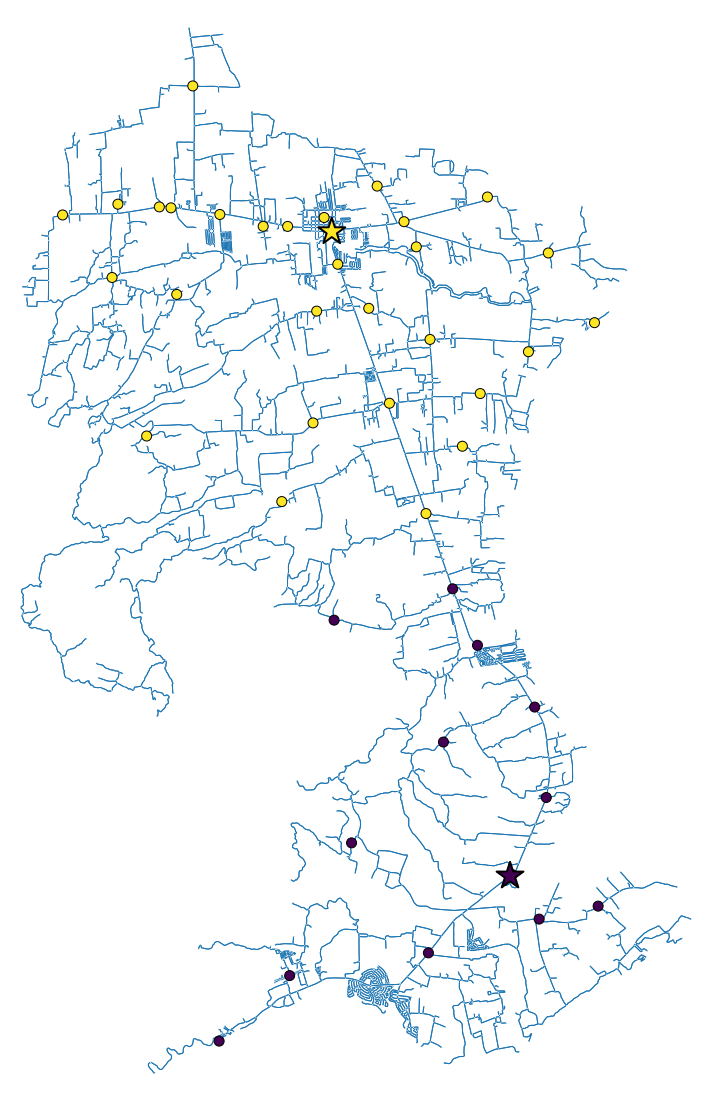

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>
San Juan Rural Health Unit I       29
Paaralang Elementarya ng Bataan    13
Name: vaccination_center, dtype: int64


In [5]:
results2 = optimal_covid_sites(n = 2, vaccination_centers_df = 'Vaccination_Centers_Table.xlsx', barangays_df = 'Barangay_Centers_Table.xlsx',
                        graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, plot = True)


phase 1 complete
phase 2 complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 37500x25500 with 0 Axes>

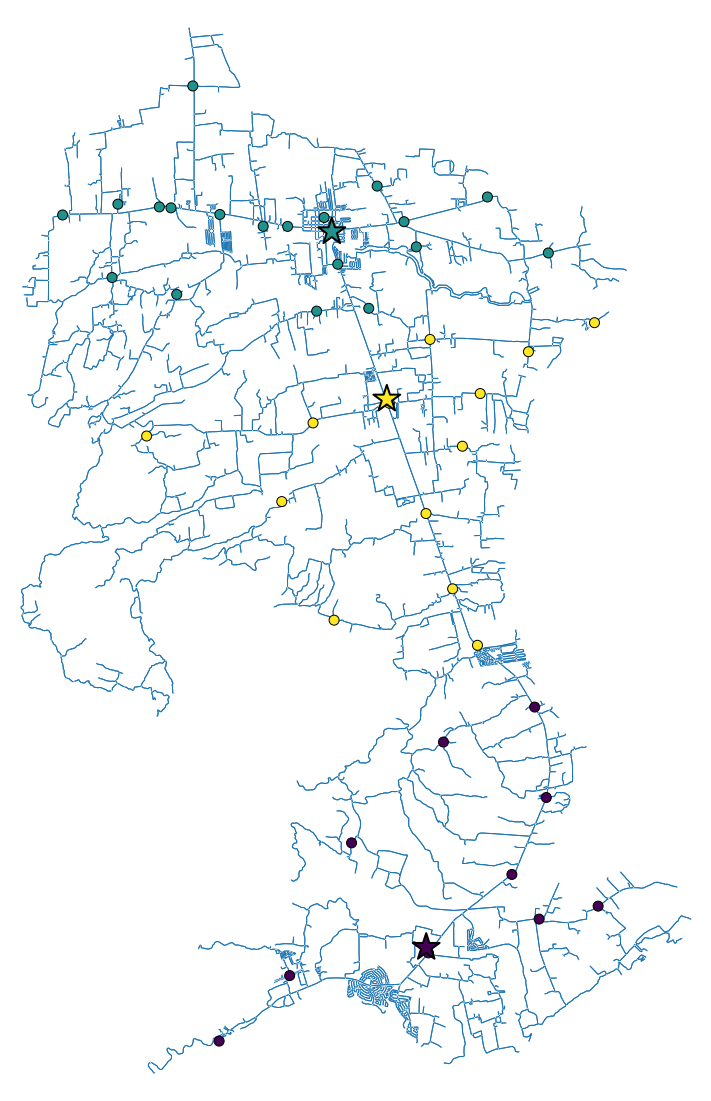

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>
San Juan Rural Health Unit I     19
San Juan Rural Health Unit II    13
Laiya Elementary School          10
Name: vaccination_center, dtype: int64


In [6]:
results3 = optimal_covid_sites(n = 3, vaccination_centers_df = 'Vaccination_Centers_Table.xlsx', barangays_df = 'Barangay_Centers_Table.xlsx',
                        graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, plot = True)

phase 1 complete
phase 2 complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 37500x25500 with 0 Axes>

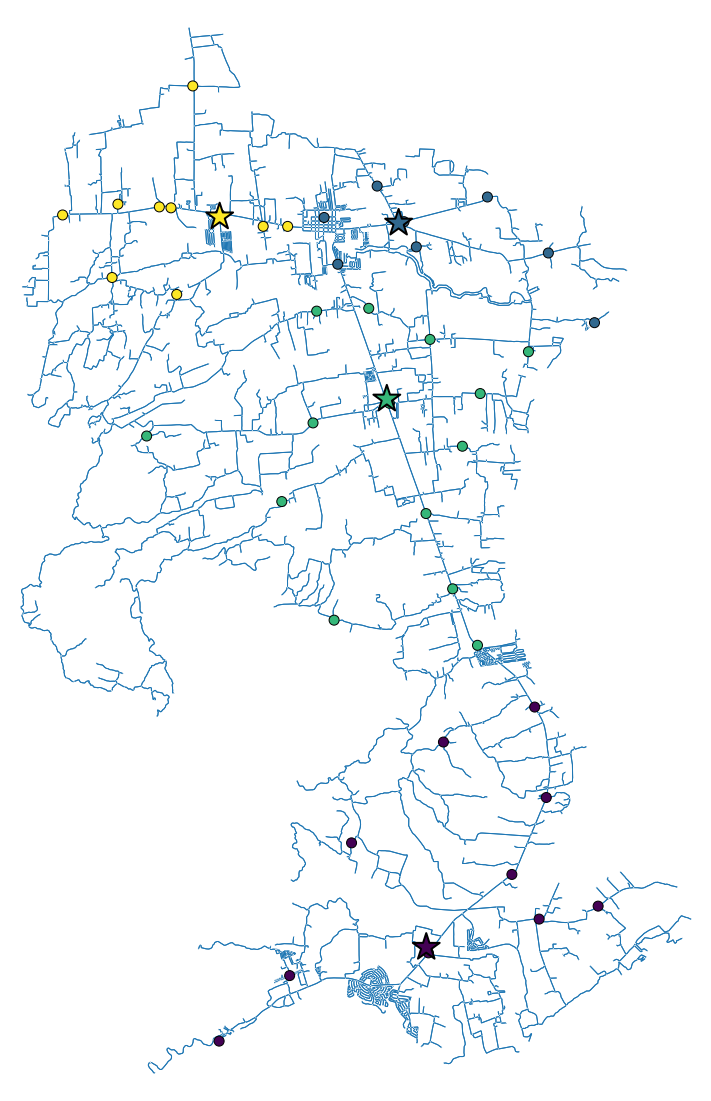

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>
San Juan Rural Health Unit II      14
Sico 1.0 National High School      10
Laiya National High School         10
San Juan Doctors Hospital, Inc.     8
Name: vaccination_center, dtype: int64


In [7]:
results4 = optimal_covid_sites(n = 4, vaccination_centers_df = 'Vaccination_Centers_Table.xlsx', barangays_df = 'Barangay_Centers_Table.xlsx',
                        graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, plot = True)